# Working with imbalanced data

In machine learning it is quite usual to have to deal with imbalanced dataset. This is particularly true in online learning for tasks such as fraud detection and spam classification. In these two cases, which are binary classification problems, there are usually many more 0s than 1s, which generally hinders the performance of the classifiers we thrown at them.

As an example we'll use the credit card dataset available in `creme`. We'll first use a `collections.Counter` to count the number of 0s and 1s in order to get an idea of the class balance.

In [1]:
import collections
from creme import datasets

X_y = datasets.CreditCard()

counts = collections.Counter(y for _, y in X_y)

for c, count in counts.items():
    print(f'{c}: {count} ({count / sum(counts.values()):.5%})')

0: 284315 (99.82725%)
1: 492 (0.17275%)


## Baseline

The dataset is quite unbalanced. For each 1 there are about 578 0s. Let's now train a logistic regression with default parameters and see how well it does. We'll measure the ROC AUC score.

In [2]:
from creme import linear_model
from creme import metrics
from creme import model_selection
from creme import preprocessing


X_y = datasets.CreditCard()

model = (
    preprocessing.StandardScaler() |
    linear_model.LogisticRegression()
)

metric = metrics.ROCAUC()

model_selection.progressive_val_score(
    X_y,
    model,
    metric,
    print_every=15_000,
    show_time=True
)

[15,000] ROCAUC: 0.899341 – 0:00:11
[30,000] ROCAUC: 0.87079 – 0:00:17
[45,000] ROCAUC: 0.899804 – 0:00:24
[60,000] ROCAUC: 0.89192 – 0:00:31
[75,000] ROCAUC: 0.890126 – 0:00:37
[90,000] ROCAUC: 0.897645 – 0:00:42
[105,000] ROCAUC: 0.889682 – 0:00:47
[120,000] ROCAUC: 0.886271 – 0:00:51
[135,000] ROCAUC: 0.883233 – 0:00:55
[150,000] ROCAUC: 0.885329 – 0:00:59
[165,000] ROCAUC: 0.897751 – 0:01:03
[180,000] ROCAUC: 0.896706 – 0:01:09
[195,000] ROCAUC: 0.896068 – 0:01:12
[210,000] ROCAUC: 0.894425 – 0:01:17
[225,000] ROCAUC: 0.893745 – 0:01:20
[240,000] ROCAUC: 0.893375 – 0:01:24
[255,000] ROCAUC: 0.89189 – 0:01:28
[270,000] ROCAUC: 0.893778 – 0:01:32


ROCAUC: 0.891071

## Importance weighting

The performance is already quite acceptable, but as we will now see we can do even better. The first thing we can do is to add weight to the 1s by using the `weight_pos` argument of the `Log` loss function.

In [3]:
from creme import optim

model = (
    preprocessing.StandardScaler() |
    linear_model.LogisticRegression(
        loss=optim.losses.Log(weight_pos=5)
    )
)

metric = metrics.ROCAUC()

model_selection.progressive_val_score(
    X_y,
    model,
    metric,
    print_every=15_000,
    show_time=True
)

[15,000] ROCAUC: 0.906964 – 0:00:04
[30,000] ROCAUC: 0.918349 – 0:00:07
[45,000] ROCAUC: 0.938641 – 0:00:11
[60,000] ROCAUC: 0.925495 – 0:00:15
[75,000] ROCAUC: 0.920024 – 0:00:19
[90,000] ROCAUC: 0.925929 – 0:00:23
[105,000] ROCAUC: 0.915362 – 0:00:27
[120,000] ROCAUC: 0.912398 – 0:00:30
[135,000] ROCAUC: 0.911679 – 0:00:34
[150,000] ROCAUC: 0.910731 – 0:00:38
[165,000] ROCAUC: 0.91989 – 0:00:42
[180,000] ROCAUC: 0.919865 – 0:00:46
[195,000] ROCAUC: 0.918189 – 0:00:50
[210,000] ROCAUC: 0.917085 – 0:00:54
[225,000] ROCAUC: 0.916455 – 0:00:58
[240,000] ROCAUC: 0.917223 – 0:01:02
[255,000] ROCAUC: 0.916282 – 0:01:05
[270,000] ROCAUC: 0.917515 – 0:01:09


ROCAUC: 0.914269

## Focal loss

The deep learning for object detection community has produced a special loss function for imbalaced learning called [focal loss](https://arxiv.org/pdf/1708.02002.pdf). We are doing binary classification, so we can plug the binary version of focal loss into our logistic regression and see how well it fairs.

In [4]:
model = (
    preprocessing.StandardScaler() |
    linear_model.LogisticRegression(loss=optim.losses.BinaryFocalLoss(2, 1))
)

metric = metrics.ROCAUC()

model_selection.progressive_val_score(
    X_y,
    model,
    metric,
    print_every=15_000,
    show_time=True
)

[15,000] ROCAUC: 0.907819 – 0:00:05
[30,000] ROCAUC: 0.902699 – 0:00:09
[45,000] ROCAUC: 0.926 – 0:00:13
[60,000] ROCAUC: 0.914868 – 0:00:17
[75,000] ROCAUC: 0.910841 – 0:00:21
[90,000] ROCAUC: 0.920638 – 0:00:29
[105,000] ROCAUC: 0.914711 – 0:00:34
[120,000] ROCAUC: 0.911864 – 0:00:39
[135,000] ROCAUC: 0.911162 – 0:00:48
[150,000] ROCAUC: 0.910189 – 0:00:52
[165,000] ROCAUC: 0.918094 – 0:00:56
[180,000] ROCAUC: 0.916794 – 0:01:01
[195,000] ROCAUC: 0.915302 – 0:01:10
[210,000] ROCAUC: 0.913043 – 0:01:14
[225,000] ROCAUC: 0.912626 – 0:01:18
[240,000] ROCAUC: 0.914699 – 0:01:23
[255,000] ROCAUC: 0.914963 – 0:01:28
[270,000] ROCAUC: 0.916283 – 0:01:40


ROCAUC: 0.913071

## Under-sampling the majority class

Adding importance weights only works with gradient-based models (which includes neural networks). A more generic, and potentially more effective approach, is to use undersamplig and oversampling. As an example, we'll under-sample the stream so that our logistic regression encounter 20% of 1s and 80% of 0s. Under-sampling has the additional benefit of requiring less training steps, and thus reduces the total training time.

In [5]:
from creme import sampling

model = (
    preprocessing.StandardScaler() |
    sampling.RandomUnderSampler(
        classifier=linear_model.LogisticRegression(),
        desired_dist={0: .8, 1: .2},
        seed=42
    )
)

metric = metrics.ROCAUC()

model_selection.progressive_val_score(
    X_y,
    model,
    metric,
    print_every=15_000,
    show_time=True
)

[15,000] ROCAUC: 0.939514 – 0:00:03
[30,000] ROCAUC: 0.948435 – 0:00:06
[45,000] ROCAUC: 0.965093 – 0:00:09
[60,000] ROCAUC: 0.956687 – 0:00:17
[75,000] ROCAUC: 0.950131 – 0:00:26
[90,000] ROCAUC: 0.956866 – 0:00:29
[105,000] ROCAUC: 0.947408 – 0:00:33
[120,000] ROCAUC: 0.942359 – 0:00:37
[135,000] ROCAUC: 0.941693 – 0:00:40
[150,000] ROCAUC: 0.943845 – 0:00:43
[165,000] ROCAUC: 0.949408 – 0:00:46
[180,000] ROCAUC: 0.948932 – 0:00:49
[195,000] ROCAUC: 0.948422 – 0:00:52
[210,000] ROCAUC: 0.948689 – 0:00:56
[225,000] ROCAUC: 0.947371 – 0:00:59
[240,000] ROCAUC: 0.949912 – 0:01:02
[255,000] ROCAUC: 0.949748 – 0:01:06
[270,000] ROCAUC: 0.950999 – 0:01:09


ROCAUC: 0.948824

The `RandomUnderSampler` class is a wrapper for classifiers. This is represented by a rectangle around the logistic regression bubble when we draw the model.

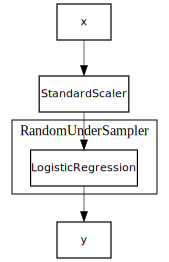

In [6]:
model.draw()

## Over-sampling the minority class

We can also attain the same class distribution by over-sampling the minority class. This will come at cost of having to train with more samples.

In [7]:
model = (
    preprocessing.StandardScaler() |
    sampling.RandomOverSampler(
        classifier=linear_model.LogisticRegression(),
        desired_dist={0: .8, 1: .2},
        seed=42
    )
)

metric = metrics.ROCAUC()

model_selection.progressive_val_score(
    X_y,
    model,
    metric,
    print_every=15_000,
    show_time=True
)

[15,000] ROCAUC: 0.939001 – 0:00:09
[30,000] ROCAUC: 0.928518 – 0:00:15
[45,000] ROCAUC: 0.948975 – 0:00:20
[60,000] ROCAUC: 0.936699 – 0:00:25
[75,000] ROCAUC: 0.9297 – 0:00:30
[90,000] ROCAUC: 0.934275 – 0:00:34
[105,000] ROCAUC: 0.924655 – 0:00:37
[120,000] ROCAUC: 0.91896 – 0:00:41
[135,000] ROCAUC: 0.917809 – 0:00:45
[150,000] ROCAUC: 0.916056 – 0:00:49
[165,000] ROCAUC: 0.925535 – 0:00:53
[180,000] ROCAUC: 0.925481 – 0:00:58
[195,000] ROCAUC: 0.923488 – 0:01:03
[210,000] ROCAUC: 0.922177 – 0:01:06
[225,000] ROCAUC: 0.921203 – 0:01:11
[240,000] ROCAUC: 0.920579 – 0:01:15
[255,000] ROCAUC: 0.920353 – 0:01:19
[270,000] ROCAUC: 0.921487 – 0:01:22


ROCAUC: 0.918082

## Sampling with a desired sample size

The downside of both `RandomUnderSampler` and `RandomOverSampler` is that you don't have any control on the amount of data the classifier trains on. The number of samples is adjusted so that the target distribution can be attained, either by under-sampling or over-sampling. However, you can do both at the same time and choose how much data the classifier will see. To do so, we can use the `RandomSampler` class. In addition to the desired class distribution, we can specify how much data to train on. The samples will both be under-sampled and over-sampled in order to fit your constraints. This is powerful because it allows you to control both the class distribution and the size of the training data (and thus the training time). In the following example we'll set it so that the model will train with 1 percent of the data.

In [8]:
model = (
    preprocessing.StandardScaler() |
    sampling.RandomSampler(
        classifier=linear_model.LogisticRegression(),
        desired_dist={0: .8, 1: .2},
        sampling_rate=.01,
        seed=42
    )
)

metric = metrics.ROCAUC()

model_selection.progressive_val_score(
    X_y,
    model,
    metric,
    print_every=15_000,
    show_time=True
)

[15,000] ROCAUC: 0.946234 – 0:00:03
[30,000] ROCAUC: 0.956145 – 0:00:06
[45,000] ROCAUC: 0.972701 – 0:00:09
[60,000] ROCAUC: 0.955377 – 0:00:11
[75,000] ROCAUC: 0.949038 – 0:00:14
[90,000] ROCAUC: 0.959151 – 0:00:17
[105,000] ROCAUC: 0.946733 – 0:00:20
[120,000] ROCAUC: 0.943587 – 0:00:23
[135,000] ROCAUC: 0.944251 – 0:00:26
[150,000] ROCAUC: 0.946132 – 0:00:29
[165,000] ROCAUC: 0.951248 – 0:00:32
[180,000] ROCAUC: 0.95303 – 0:00:35
[195,000] ROCAUC: 0.95088 – 0:00:38
[210,000] ROCAUC: 0.951606 – 0:00:41
[225,000] ROCAUC: 0.949907 – 0:00:44
[240,000] ROCAUC: 0.95294 – 0:00:47
[255,000] ROCAUC: 0.952255 – 0:00:50
[270,000] ROCAUC: 0.953966 – 0:00:53


ROCAUC: 0.951294

## Hybrid approach

As you might have guessed by now, nothing is stopping you from mixing imbalanced learning methods together. As an example, let's combine `sampling.RandomUnderSampler` and the `weight_pos` parameter from the `optim.losses.Log` loss function.

In [9]:
model = (
    preprocessing.StandardScaler() |
    sampling.RandomUnderSampler(
        classifier=linear_model.LogisticRegression(
            loss=optim.losses.Log(weight_pos=5)
        ),
        desired_dist={0: .8, 1: .2},
        seed=42
    )
)

metric = metrics.ROCAUC()

model_selection.progressive_val_score(
    X_y,
    model,
    metric,
    print_every=15_000,
    show_time=True
)

[15,000] ROCAUC: 0.957494 – 0:00:03
[30,000] ROCAUC: 0.967154 – 0:00:06
[45,000] ROCAUC: 0.976699 – 0:00:09
[60,000] ROCAUC: 0.974157 – 0:00:11
[75,000] ROCAUC: 0.970901 – 0:00:14
[90,000] ROCAUC: 0.974191 – 0:00:17
[105,000] ROCAUC: 0.964133 – 0:00:20
[120,000] ROCAUC: 0.963783 – 0:00:23
[135,000] ROCAUC: 0.964123 – 0:00:26
[150,000] ROCAUC: 0.965729 – 0:00:29
[165,000] ROCAUC: 0.968144 – 0:00:32
[180,000] ROCAUC: 0.968855 – 0:00:35
[195,000] ROCAUC: 0.968339 – 0:00:37
[210,000] ROCAUC: 0.967406 – 0:00:40
[225,000] ROCAUC: 0.966696 – 0:00:43
[240,000] ROCAUC: 0.968059 – 0:00:46
[255,000] ROCAUC: 0.968884 – 0:00:49
[270,000] ROCAUC: 0.969511 – 0:00:52


ROCAUC: 0.968294